In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.search import search
from earthtext.datamodules.components import chipmultilabel
from earthtext.osm.multilabel import kvmerged
from joblib import Parallel, delayed
from importlib import reload
reload(chipmultilabel)
reload(search)

<module 'earthtext.search.search' from '/home/ubuntu/earth-text/src/earthtext/search/search.py'>

# load an initialize searcher object

- `search_target` can be `train`, `test` or `val`

In [3]:
reload(search)
model_ckpt_fname = "/opt/data/models/osm_emcoder_2024-04-25_12:01.ckpt"
searcher = search.OSMClayModelSearcher(model_ckpt_fname, search_target='train')

2024-04-30 00:13:40.165 | INFO     | earthtext.search.search:__init__:75 - search target is 'train'


In [4]:
searcher.setup()

2024-04-30 00:13:50.922 | INFO     | earthtext.search.search:setup:113 - loading model
2024-04-30 00:13:50.978 | INFO     | earthtext.search.search:setup:118 - initializing dataloaders
2024-04-30 00:13:52.331 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-30 00:13:55.361 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 60295 chip files (out of 60396)
2024-04-30 00:13:55.362 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-04-30 00:13:56.070 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-30 00:13:56.685 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092

# build a search query

In [4]:
class TestSearch:

    def __init__(self, searcher, query_source = 'test'):
        """
        searcher: searcher objects
        query_dataloader: from where queries are sampled
        """
        logger.info(f"search target is {searcher.search_target}, query source is {query_source}")
        self.searcher = searcher
        self.query_source = query_source
        self.query_dataloader = searcher.get_dataloader(query_source)
        logger.info("loading all samples from query source")
        self.q_chip_ids,\
        self.q_embeddings,\
        self.q_normalized_osmvectors = search.get_embeddings_osmvectors_predictions(self.query_dataloader)
        self.q_original_osmvectors = chipmultilabel.unnormalize_osm_vector(self.q_normalized_osmvectors)

    def sample_queries(self, n_queries):
        o = self.q_normalized_osmvectors 
        idxs = np.random.permutation(len(o['osm_ohecount']))[:n_queries]
        normalized_query_vector = {k: v[idxs] for k,v in o.items()}
        original_query_vector   = {k: v[idxs] for k,v in self.q_original_osmvectors.items()}

        return {'normalized_query_vector': normalized_query_vector,
                'original_query_vector': original_query_vector,
                'indexes': idxs
                }

    def sample_queries_with_conditions(self, min_counts={}, max_counts={}, min_areas={}, max_areas={}, n_samples=10):
        """
        for instance
            min_counts = {'building=*':100}
            max_counts = {'natural=*': 0}
        """
        query_min_counts = np.zeros(len(kvmerged.inverse_codes))
        for k,v in min_counts.items():
            query_min_counts[kvmerged.keyvals_codes[k]] = v
        
        query_max_counts = np.zeros(len(kvmerged.inverse_codes)) + np.inf
        for k,v in max_counts.items():
            query_max_counts[kvmerged.keyvals_codes[k]] = v

        query_min_areas = np.zeros(len(kvmerged.inverse_codes))
        for k,v in min_areas.items():
            query_min_areas[kvmerged.keyvals_codes[k]] = v
        
        query_max_areas = np.zeros(len(kvmerged.inverse_codes)) + np.inf
        for k,v in max_areas.items():
            query_max_areas[kvmerged.keyvals_codes[k]] = v

        filter_cmin = self.q_original_osmvectors['osm_ohecount']>=query_min_counts
        filter_cmax = self.q_original_osmvectors['osm_ohecount']<=query_max_counts

        filter_amin = self.q_original_osmvectors['osm_ohearea']>=query_min_areas
        filter_amax = self.q_original_osmvectors['osm_ohearea']<=query_max_areas

        
        compliant_indexes = np.argwhere(np.all(filter_cmin * filter_cmax * filter_amin * filter_amax, axis=1))[:,0]
        idxs = np.random.permutation(compliant_indexes)[:n_samples]
        
        normalized_query_vector = {k: v[idxs] for k,v in self.q_normalized_osmvectors.items()}
        original_query_vector   = {k: v[idxs] for k,v in self.q_original_osmvectors.items()}

        return {'normalized_query_vector': normalized_query_vector,
                'original_query_vector': original_query_vector,
                'indexes': idxs
                }

    
    def predict_embeddings(self, normalized_query_vector):
        return self.searcher.model(normalized_query_vector).detach()

    def make_search(self, predicted_embedding, topn=None):
        idxs, scores = search.get_similarity_sorted_indexes(self.searcher.searchdb['embeddings'], predicted_embedding, topn=topn)
        search_result = {k:({kk:vv[idxs] for kk,vv in v.items()} if isinstance(v, dict) else np.r_[v][idxs]) for k,v in self.searcher.searchdb.items()}
        
        search_result['idxs'] = idxs
        search_result['scores'] = scores
        return search_result

    def get_tagnames(self, original_query_vector, search_result, min_count=1):
        query_tags = self.searcher.model.get_tag_names_for_osmcounts(original_query_vector)
        search_result['tags'] = [list(self.searcher.model.get_tag_names_for_osmcounts(i)) for i in search_result['original_osm_vectors']['osm_ohecount']]
        
        return query_tags, search_result
        

In [14]:
ts = search.QuerySampler(searcher, query_source='train')

2024-04-30 00:19:55.750 | INFO     | earthtext.search.search:__init__:159 - search target is train, query source is train
2024-04-30 00:19:55.751 | INFO     | earthtext.search.search:__init__:163 - loading all samples from query source
 11% (215 of 1885) |##                   | Elapsed Time: 0:00:01 ETA:   0:00:13Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7508f9068220>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100% (1

# define a user query

In [8]:
chipm2 = 256*256*100 # how many square meters in a chip

In [10]:
# i want between 1 and 10 buildings, with water=lake of at least 1% of the chips surface area
min_counts, max_counts,  min_areas, max_areas = {'building=*': 1}, { 'building=*': 10}, {'water=lake': .01*chipm2} ,{}

In [17]:
# autocomplete the query by sampling osm vectors that comply with the user query
q = ts.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
                                       min_areas = min_areas, max_areas = max_areas,
                                       n_samples=10)
print (f"sampled {len(q)} osm vectors complying with the user query")

sampled 3 osm vectors complying with the user query


# inspect the sampled chips with which the user query is autocompleted

min areas and min counts


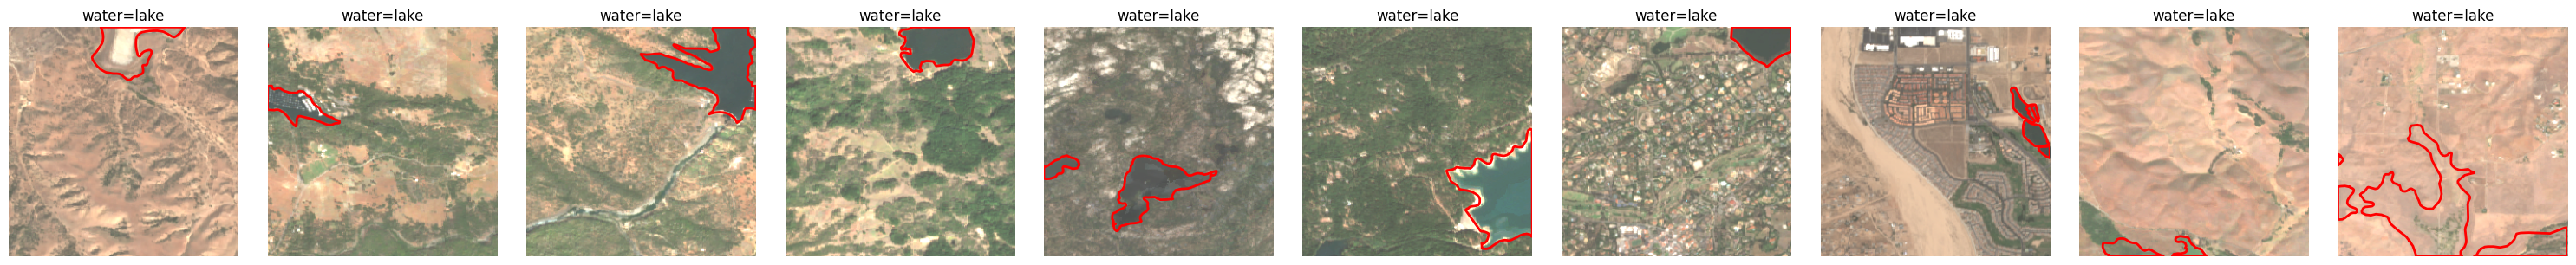

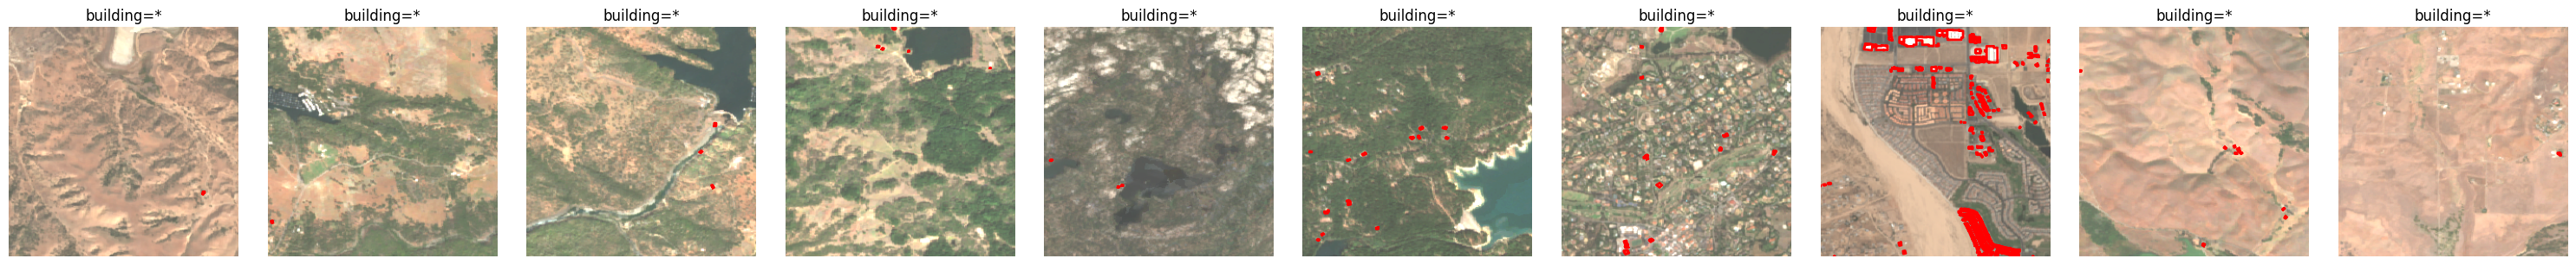

In [20]:
ts.query_dataloader.dataset.disable_chip_loading = False
ts.query_dataloader.dataset.reset_cache()

for tag in list(min_areas.keys()) + list(min_counts.keys()):
    for ax,qi in subplots(len(q['indexes'])):
        ts.query_dataloader.dataset.plot_chip_with_tags(q['indexes'][qi], [tag])
        plt.title(tag)
print("min areas and min counts")

# build the osm vector for which to predict clay embeddings

mode can be

- `sample_autocompleted`: one random osm vector is selected from above
- `average_autocompleted`: the above osm vectors are averaged

note that the `osmencoder` expects osmvectors normalized (counts, areas and lengths substracted the distribution mean and divided by their stdev), so `query_osmvector` is normalized. we also store `query_original_osmcount` for visualization purposes only

In [61]:
mode = "average_autocompleted"
#mode = "sample_autocompleted"


In [67]:
if mode == "sample_autocompleted":
    qi = np.random.randint(len(q['indexes']))
    query_osmvector = {k:v[qi].reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    query_original_osmcount = q['original_query_vector']['osm_ohecount'][qi]

elif mode == 'average_autocompleted':
    query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    query_original_osmcount = q['original_query_vector']['osm_ohecount'].mean(axis=1)

# use the osmencoder to predict the clay embeddings

In [68]:
p = searcher.predict_embeddings(query_osmvector)[0]
p.shape


torch.Size([768])

# search for similar embeddings

In [70]:
r = searcher.make_search(p, topn=10)
r.keys()

NameError: name 'search' is not defined

In [480]:
chipm2 = 256*256*100

min_counts =  {'highway=*':10, 'natural=*': 10}
min_counts, max_counts = {'building=*': 100}, {'sport=baseball': 0}
min_counts, max_counts = {'building=*': 100, 'water=lake': 1}, {'sport=baseball': 0}
min_counts, max_counts = {'water=lake': 1, 'building=*':1}, {}

min_counts, max_counts = {'water=lake': 1, 'building=*':1}, {}
#min_counts, max_counts, min_areas, max_areas = {}, {'building=*':0}, {'landuse=farmland': 1000000}, {}
#min_counts, max_counts, min_areas, max_areas = {}, {}, {'landuse=farmland': 1000000}, {}
#min_counts, max_counts, min_areas, max_areas = {}, {}, {'water=lake': .1*chipm2, 'building=*':.001*chipm2}, {}
min_counts, max_counts, min_areas, max_areas = {'sport=baseball':5}, {}, {'waterway=*': .0001*chipm2}, {}
min_counts, max_counts,  min_areas, max_areas = {'building=*': 1}, { 'building=*': 10}, {'water=lake': .01*chipm2} ,{}
min_counts, max_counts, min_areas, max_areas = {'sport=baseball':5 }, {'building=*': 0}, {}, {}

min_counts, max_counts = {'building=*': 100}, { }
min_areas, max_areas = {'water=lake': .01*chipm2} ,{}


min_counts, max_counts,  min_areas, max_areas = {'sport=baseball':5}, {'building=*': 0}, {} ,{}


#min_counts, max_counts, min_areas, max_areas = {}, {}, {'landuse=industrial':.1*chipm2}, {'landuse=farmland': .1*chipm2}

min_counts, max_counts, min_areas, max_areas = {'sport=baseball':5}, {}, {'waterway=*': .0001*chipm2}, {}

q = ts.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
                                       min_areas = min_areas, max_areas = max_areas,
                                       n_samples=10)
len(q['indexes'])

1

In [481]:
qi = np.random.randint(len(q['indexes']))
p = ts.predict_embeddings(q['normalized_query_vector'])
r = ts.make_search(p[qi], topn=10)
query_tags, r = ts.get_tagnames(q['original_query_vector']['osm_ohecount'][qi], r)

qi

0

In [482]:
qvector_averaged = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
p = ts.predict_embeddings(qvector_averaged)[0]
r = ts.make_search(p, topn=10)
query_tags, r = ts.get_tagnames(qvector_averaged['osm_ohecount'][0], r)
query_tags

array(['amenity=*', 'amenity=parking', 'building=school', 'highway=*',
       'highway=track', 'leisure=*', 'leisure=pitch', 'sport=*',
       'sport=baseball', 'surface=*', 'surface=asphalt',
       'highway=residential'], dtype='<U20')

In [483]:
ts.query_dataloader.dataset.disable_chip_loading = False
ts.query_dataloader.dataset.reset_cache()
c = ts.query_dataloader.dataset[q['indexes'][qi]]
c.keys()

dict_keys(['multilabel', 'chip_id', 'chip', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

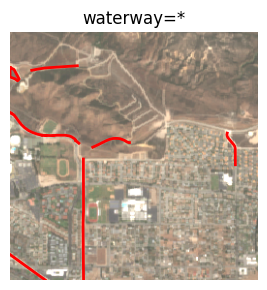

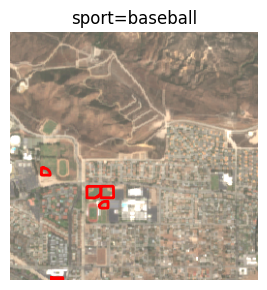

In [484]:

for tag in list(min_areas.keys()) + list(min_counts.keys()):
    for ax,qi in subplots(len(q['indexes'])):
        ts.query_dataloader.dataset.plot_chip_with_tags(q['indexes'][qi], [tag])
        plt.title(tag)

In [485]:

for tag in list(max_areas.keys()) + list(max_counts.keys()):
    for ax,qi in subplots(len(q['indexes'])):
        ts.query_dataloader.dataset.plot_chip_with_tags(q['indexes'][qi], [tag])
        plt.title(tag)

In [486]:
ds = ts.searcher.get_dataloader().dataset

In [487]:
ds.reset_cache()
ds.disable_chip_loading = False

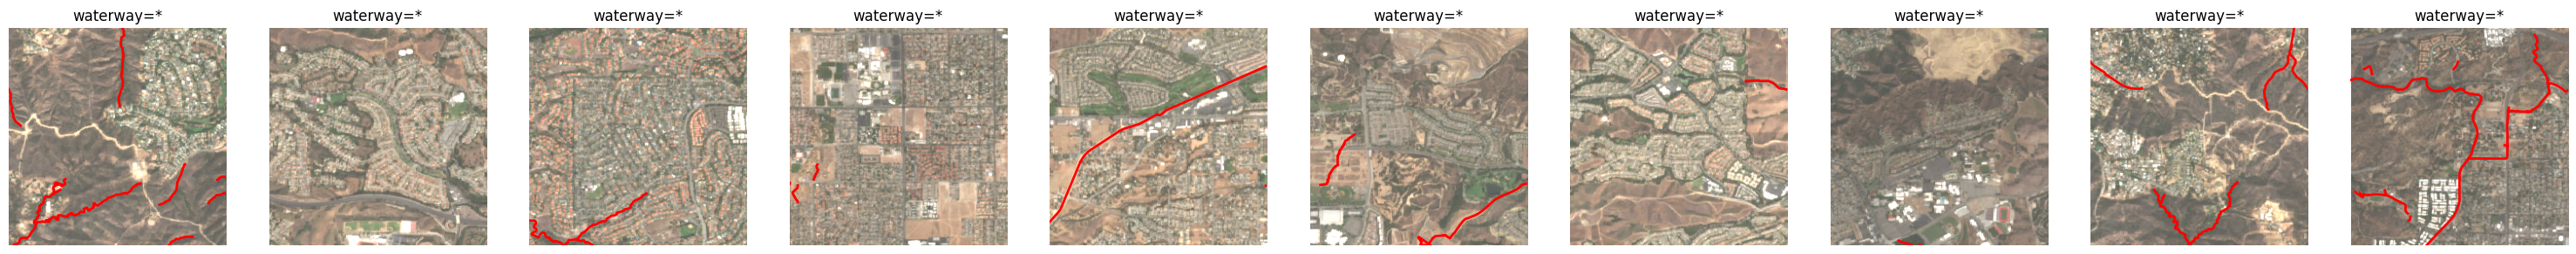

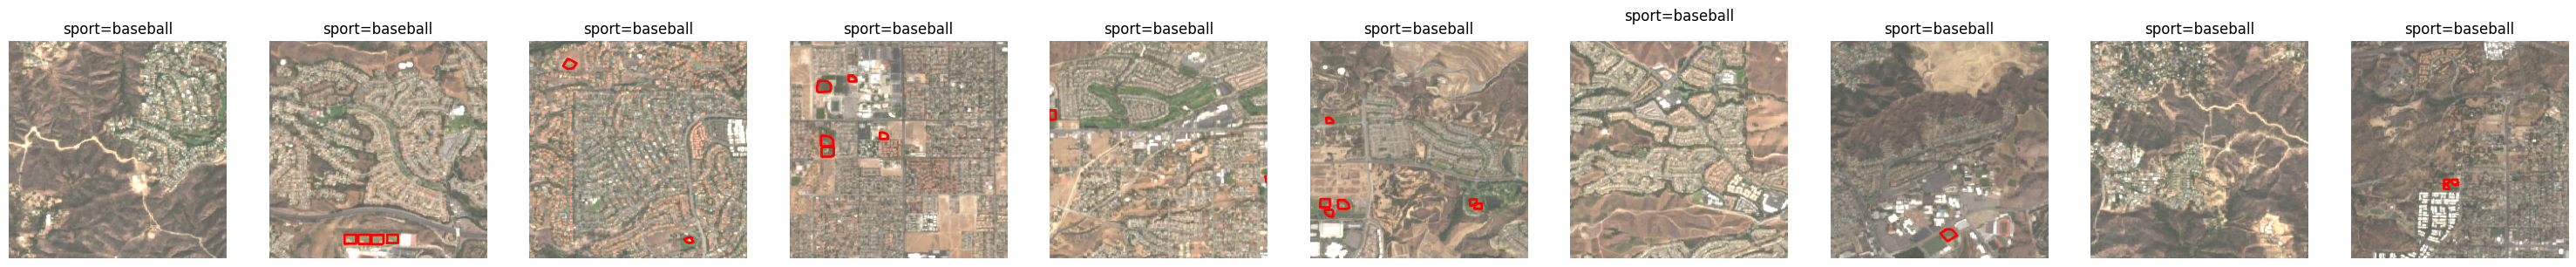

In [488]:
for tag in list(min_areas.keys()) + list(min_counts.keys()):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)

In [479]:
for tag in list(max_areas.keys()):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)

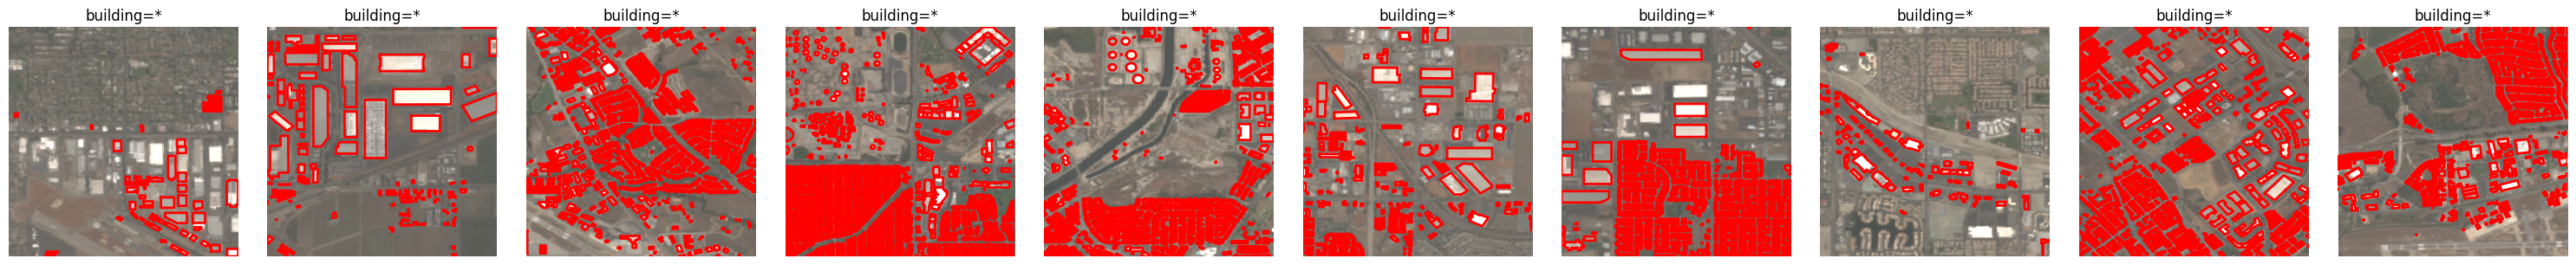

In [385]:
for tag in list(max_counts.keys()):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)

In [59]:
ts.searcher.model.osm_tags_names

array(['amenity=*', 'amenity=parking', 'building=*',
       'building=apartments', 'building=house', 'building=industrial',
       'building=residential', 'building=school', 'building=warehouse',
       'highway=*', 'highway=track', 'landuse=*', 'landuse=commercial',
       'landuse=farmland', 'landuse=grass', 'landuse=industrial',
       'landuse=residential', 'landuse=retail', 'leisure=*',
       'leisure=park', 'leisure=pitch', 'natural=*', 'natural=water',
       'parking=*', 'parking=surface', 'power=*', 'sport=*',
       'sport=baseball', 'surface=*', 'surface=asphalt', 'water=lake',
       'waterway=*', 'highway=motorway', 'highway=residential',
       'waterway=stream'], dtype='<U20')

In [25]:
r['idxs']

array([39120, 57157, 38850, 25963, 21229,  2875,  9750, 17826,  7283,
       36223])

In [26]:
ds.metadata.index[r['idxs']]

Index(['3824343dd3472', '14fdaeb8fedec', '0f7404a830f50', '16d4e2e5cb0c7',
       '1bc20b6182c74', '327b8cdf5a4da', '13444b5f1ba18', '33d0eb1b237a2',
       '1cab1326270cb', '07899939a1c20'],
      dtype='object', name='chip_id')

In [27]:
searcher.searchdb.

dict_keys(['chip_ids', 'normalized_osm_vectors', 'embeddings', 'original_osm_vectors'])

In [116]:
qi = 0
query_predicted_embeddings = self.model(normalized_query_vector).detach()[qi]
print (qi, searcher.model.get_tag_names_for_osmcounts(original_query_vector['osm_ohecount'][qi].astype(int)))

0 ['amenity=*' 'amenity=parking' 'building=*' 'building=apartments'
 'highway=*' 'landuse=*' 'landuse=grass' 'landuse=residential' 'leisure=*'
 'leisure=park' 'leisure=pitch' 'natural=*' 'natural=water' 'surface=*'
 'surface=asphalt' 'highway=residential']


In [117]:
idxs, scores = search.get_similarity_sorted_indexes(self.searchdb['embeddings'], query_predicted_embeddings, topn=10)
search_result = {'idxs': idxs,
                 'scores': scores}


In [118]:
searcher.model.get_tag_names_for_osmcounts(searcher.searchdb['original_osm_vectors']['osm_ohecount'][idxs[0]].astype(int))

array(['amenity=*', 'amenity=parking', 'building=*',
       'building=apartments', 'building=house', 'building=industrial',
       'building=residential', 'building=school', 'highway=*',
       'highway=track', 'landuse=*', 'landuse=grass', 'leisure=*',
       'leisure=park', 'leisure=pitch', 'natural=*', 'parking=*',
       'parking=surface', 'power=*', 'sport=*', 'sport=baseball',
       'surface=*', 'surface=asphalt', 'waterway=*',
       'highway=residential', 'waterway=stream'], dtype='<U20')

In [23]:
searcher.searchdb['original_osm_vectors'].keys()

dict_keys(['osm_ohecount', 'osm_ohearea', 'osm_ohelength'])

In [23]:
def get_tag_names_for_osmcounts(self, osmcounts):
    # in case we are given a full unfiltered vector
    if len(osmcounts)==99:
        osmcounts = osmcounts[self.osm_tags_indexes]

    r = np.r_[self.osm_tags_names]osmcounts>0]
    return r
    

In [24]:
get_tag_names_for_osmcounts(searcher.model, query_vector['osm_ohelength'][0])

TypeError: only integer scalar arrays can be converted to a scalar index

In [17]:
osmcounts = query_vector['osm_ohecount']
searcher.model.osm_tags_names[osmcounts>0]

TypeError: only integer scalar arrays can be converted to a scalar index

In [19]:
osmcounts.shape

(10, 99)

In [9]:
query_vector.keys()

dict_keys(['osm_ohecount', 'osm_ohearea', 'osm_ohelength'])

In [61]:
uquery_vector = chipmultilabel.unnormalize_osm_vector(query_vector)

In [41]:
search_dataset = self.get_search_dataset()
search_dataset.cache = {}
search_dataset.disable_chip_loading = False
search_result['chips'] = [search_dataset[idx] for idx in idxs]

In [42]:
search_result['chips'][0].keys()

dict_keys(['multilabel', 'chip_id', 'chip', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

In [88]:
(uquery_vector['osm_ohecount'].astype(int)[query_idx]>0)[np.r_[self.model.osm_tags_indexes]]

array([False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False])

In [94]:
query_osm_classnames = [v for k,v in kvmerged.inverse_codes.items() if k in self.model.osm_tags_indexes and uquery_vector['osm_ohecount'][query_idx][k]>0]
query_osm_classnames

['amenity=*',
 'amenity=parking',
 'highway=*',
 'highway=track',
 'surface=asphalt',
 'highway=residential']

In [95]:
m = self.model

In [96]:
m.osm_tags_indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 14, 15, 18, 20, 23, 25, 30,
       31, 33, 37, 38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96,
       98])

In [97]:
osm_tags_names = [kvmerged.inverse_codes[i] for i in m.osm_tags_indexes]
osm_tags_names

['amenity=*',
 'amenity=parking',
 'building=*',
 'building=apartments',
 'building=house',
 'building=industrial',
 'building=residential',
 'building=school',
 'building=warehouse',
 'highway=*',
 'highway=track',
 'landuse=*',
 'landuse=commercial',
 'landuse=farmland',
 'landuse=grass',
 'landuse=industrial',
 'landuse=residential',
 'landuse=retail',
 'leisure=*',
 'leisure=park',
 'leisure=pitch',
 'natural=*',
 'natural=water',
 'parking=*',
 'parking=surface',
 'power=*',
 'sport=*',
 'sport=baseball',
 'surface=*',
 'surface=asphalt',
 'water=lake',
 'waterway=*',
 'highway=motorway',
 'highway=residential',
 'waterway=stream']

In [78]:
restricted_osm_classnames = np.r_[[kvmerged.inverse_codes[i] for i in self.model.osm_tags_indexes]]
restricted_osm_classnames[uquery_vector['osm_ohecount'].astype(int)[query_idx]>0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 35 but corresponding boolean dimension is 99

In [81]:
len(uquery_vector['osm_ohecount'].astype(int)[query_idx]>0)

99

In [80]:
[uquery_vector['osm_ohecount'].astype(int)[query_idx]>0]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False])]

## setup dataloader

In [4]:
model_ckpt_fname = "/opt/data/models/osm_emcoder_2024-04-25_12:01.ckpt"
model_conf_fname = "/opt/data/models/osm_emcoder_2024-04-25_12:01.yaml"
conf = OmegaConf.load(model_conf_fname)
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-01 00:49:24.693 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:12 Time:  0:00:120001
2024-05-01 00:49:37.052 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 60295 chip files (out of 60396)
2024-05-01 00:49:37.052 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-01 00:49:37.891 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-01 00:49:38.863 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 12288 chip files (out of 12304)
2024-05-01 00:49:38.864 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

## setup model

In [7]:
m = hydra.utils.instantiate(conf.model)

# retrieve everything: osmvectors, embeddings and predictions

In [8]:
def get_top10_sim(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)
    top10idxs = np.argsort(sims)[-10:]
    return top10idxs


def get_targets_and_predictions(dataloader):
    targets = []
    predictions = []
    inputs = []
    chip_ids = []

    for batch in pbar(dataloader):
        t = batch['embedding']
        o = m(batch)
        x = m.make_input(batch)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)

        for xi in x.detach().numpy():
            inputs.append(xi)
        
        for ci in batch['chip_id']:
            chip_ids.append(ci)

    targets = np.r_[targets]
    predictions = np.r_[predictions]
    inputs = np.r_[inputs]
    return targets, predictions, inputs, chip_ids


In [9]:
# load all data from selected split

dl.disable_chip_loading()

def similarity(t1,t2):
    
    t1 = t1 / np.linalg.norm(t1)
    t2 = t2 / np.linalg.norm(t2)
    return t1.dot(t2) 

def get_similarity_sorted_indexes(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)

    sorted_idxs = np.argsort(sims)[::-1]
    return sorted_idxs, sims[sorted_idxs]

unnormalize_counts = lambda x: (x*chipmultilabel.ohecount_std[conf.model.osm_tags_indexes] + chipmultilabel.ohecount_mean[conf.model.osm_tags_indexes]).astype(int)
unnormalize_areas  = lambda x: (x*chipmultilabel.ohearea_std[conf.model.osm_tags_indexes] + chipmultilabel.ohearea_mean[conf.model.osm_tags_indexes]).astype(int)
unnormalize_lengths = lambda x: (x*chipmultilabel.ohelength_std[conf.model.osm_tags_indexes] + chipmultilabel.ohelength_mean[conf.model.osm_tags_indexes]).astype(int)


dataloaders = {
    'train': dl.train_dataloader(),
    'test': dl.test_dataloader(),
    'val': dl.val_dataloader()
}

inference_items = {}
for k,d in dataloaders.items(): 
    d.dataset.normalize_input = True
    d.dataset.get_chip_id = True
    t,p,i,c = get_targets_and_predictions(d)
    inference_items[k] = {    
        'targets': t,
        'predictions': p,
        'inputs': i,
        'chip_ids': c
    }


100% (1885 of 1885) |####################| Elapsed Time: 0:00:56 Time:  0:00:560004
100% (420 of 420) |######################| Elapsed Time: 0:00:12 Time:  0:00:120001
100% (384 of 384) |######################| Elapsed Time: 0:00:11 Time:  0:00:110001


In [10]:
pd.DataFrame({k: {kk:vv.shape for kk,vv in v.items() if kk!='chip_ids'} for k,v in inference_items.items()})

train          test           val
targets      (60295, 768)  (13411, 768)  (12288, 768)
predictions  (60295, 768)  (13411, 768)  (12288, 768)
inputs       (60295, 105)  (13411, 105)  (12288, 105)

# compute topk_precision_mean

In [11]:
# function to call in parallel
def _compute_topk_precision_mean(query_idx, query_source, search_target, min_counts=1, min_areas=None, mink=10, maxk=100):


    if (min_counts is not None) + (min_areas is not None) != 1:
        raise ValueError("must set exactly one of 'min_counts' and 'min_areas'")
    
    qidx = query_idx
    
    # get predicted embedding
    query_osm_vector = inference_items[query_source]['inputs'][qidx]
    query_predicted_embedding = inference_items[query_source]['predictions'][qidx]

    # make search
    sorted_search_result_idxs, sorted_search_result_scores  = get_similarity_sorted_indexes(inference_items[search_target]['targets'], query_predicted_embedding)
    sorted_search_result_osmvectors = inference_items[search_target]['inputs'][sorted_search_result_idxs]

    # split counts, areas and lengths and unnormalize osmvectors (to have actual numbers back)
    n_osm_classes = len(conf.model.osm_tags_indexes)
    query_osm_vector_counts = query_osm_vector[:n_osm_classes]
    query_osm_vector_areas  = query_osm_vector[n_osm_classes:n_osm_classes*2]
    query_osm_vector_lengths = query_osm_vector[n_osm_classes*2:]
    
    sorted_search_result_osmvectors_counts  = sorted_search_result_osmvectors[:, :n_osm_classes]
    sorted_search_result_osmvectors_areas   = sorted_search_result_osmvectors[:, n_osm_classes:n_osm_classes*2]
    sorted_search_result_osmvectors_lengths = sorted_search_result_osmvectors[:, n_osm_classes*2:]
    
    usorted_search_result_osmvectors_counts = unnormalize_counts(sorted_search_result_osmvectors_counts)
    usorted_search_result_osmvectors_areas = unnormalize_areas(sorted_search_result_osmvectors_areas)
    usorted_search_result_osmvectors_lengths = unnormalize_lengths(sorted_search_result_osmvectors_lengths)
    
    uquery_osm_vector_counts = unnormalize_counts(query_osm_vector_counts)
    uquery_osm_vector_areas = unnormalize_areas(query_osm_vector_areas)
    uquery_osm_vector_lengths = unnormalize_lengths(query_osm_vector_lengths)

    # filter for presence of classes both in the response and the query 
    if min_counts is not None:
        osmclasses_in_query = np.argwhere(uquery_osm_vector_counts>=min_counts) [:,0]
    elif min_areas is not None:
        osmclasses_in_query = np.argwhere(uquery_osm_vector_areas>=min_areas) [:,0]
        
    osmquery_classes_present_in_response = (usorted_search_result_osmvectors_counts[:, osmclasses_in_query]>1).astype(int)
    
    # average precision per osm class in top-k results
    topk_precision = np.r_[[osmquery_classes_present_in_response[:k].mean(axis=0) for k in range(mink, maxk+1)]]
    topk_precision_mean = {k:v for k,v in zip(osmclasses_in_query, topk_precision.mean(axis=0))}

    return topk_precision_mean

In [12]:
len(inference_items['test']['inputs'])

13411

In [13]:
query_source = 'test'
search_target = 'train'

def compute_topk_precision_mean(query_source, search_target, min_counts=None, min_areas=None, mink=10, maxk=100, n_samples=1000, plot=False):
    if n_samples is None:
        n_samples = len(inference_items[query_source]['inputs'])
    topk = Parallel(n_jobs=-1, verbose=1)(delayed(_compute_topk_precision_mean)(query_idx=qidx, 
                                                                               query_source=query_source, 
                                                                               search_target=search_target, 
                                                                               min_counts=min_counts,
                                                                               min_areas=min_areas,
                                                                               mink=mink, 
                                                                               maxk=maxk)\
                                           for qidx in np.random.permutation(len(inference_items[query_source]['inputs']))[:n_samples])
    topk = pd.DataFrame(topk).fillna(-1)
    topk = topk[sorted(topk.columns)]
    topk_summary = pd.DataFrame([{c: topk[topk[c]>=0][c].values.mean() for c in topk.columns}]).T
    topk_summary.index = [kvmerged.inverse_codes[c] for c in topk_summary.index]

    if plot:
        topk_summary.plot(kind='bar', figsize=(20,3))
        plt.grid(); plt.ylim(0,1)   
        n = len(inference_items[query_source]['inputs'])
        if n_samples is None:
            qstext = f"using all {n} samples"
        else:
            qstext = f"using {n_samples} samples out of {n}"

        n = len(inference_items[search_target]['inputs'])
        sttext = f"{n} data points"
        
        title = f"top k precision mean for k between {mink} and {maxk} :: query source {query_source} ({qstext}) :: search target {search_target} ({sttext})"
        if min_counts is not None:
            title += f" :: min_counts {min_counts}"
        if min_areas is not None:
            title += f" :: min_areas {min_areas}"
        plt.title(title)
        
    return topk_summary
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

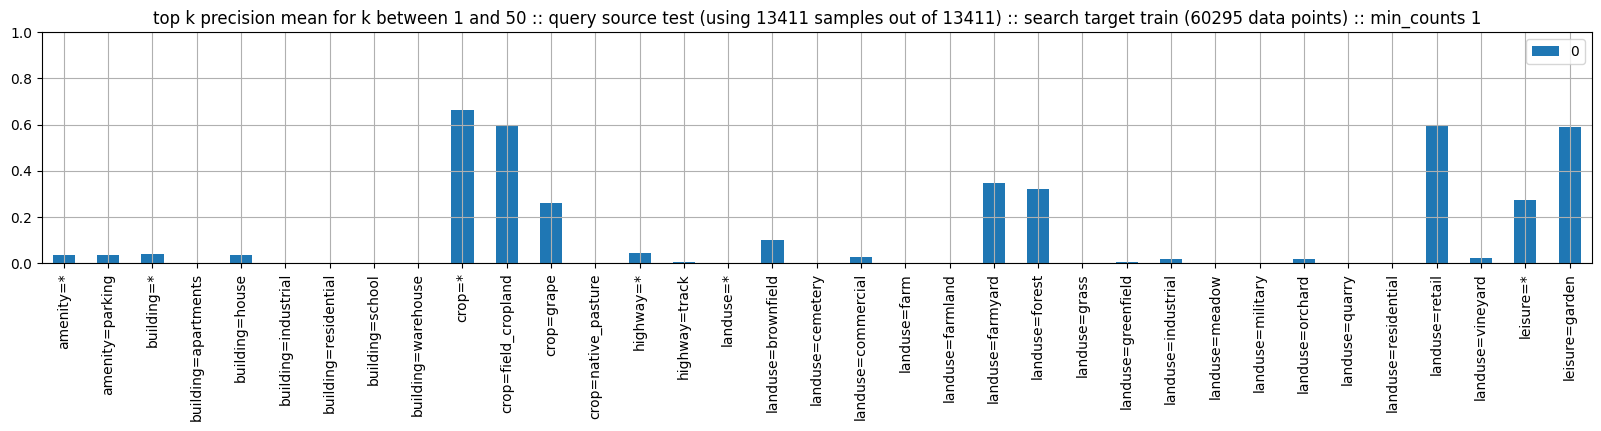

In [14]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=1, 
                            maxk=50,
                            min_counts=1,
                            n_samples=None,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

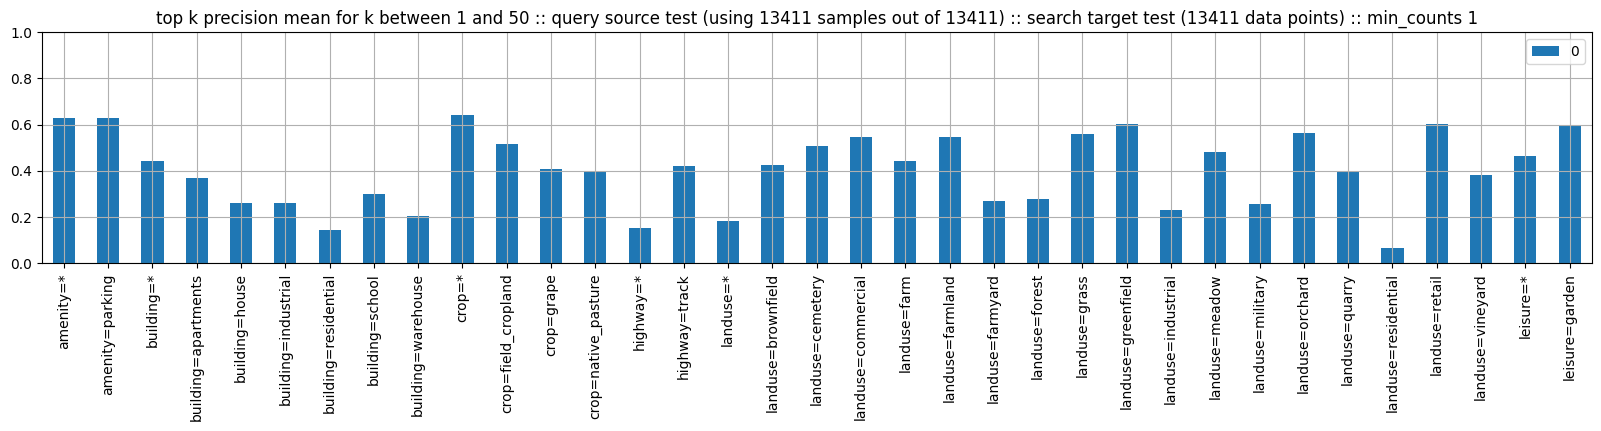

In [115]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target='test', 
                            mink=1, 
                            maxk=50,
                            min_counts=1,
                            n_samples=None,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

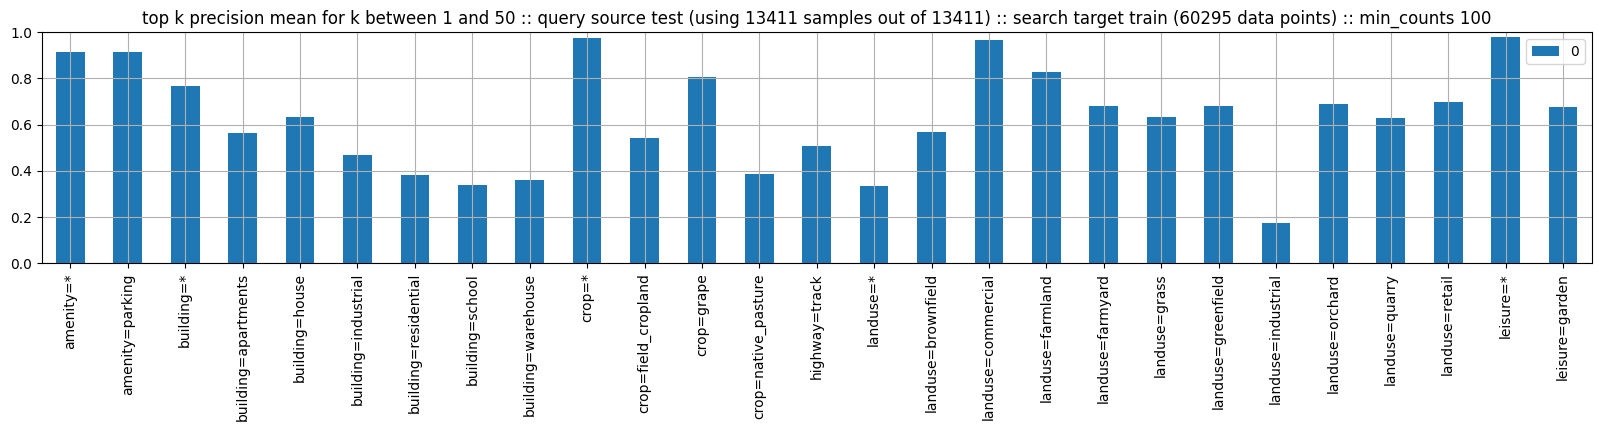

In [116]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=1, 
                            maxk=50,
                            min_counts=100,
                            n_samples=None,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.4min finished


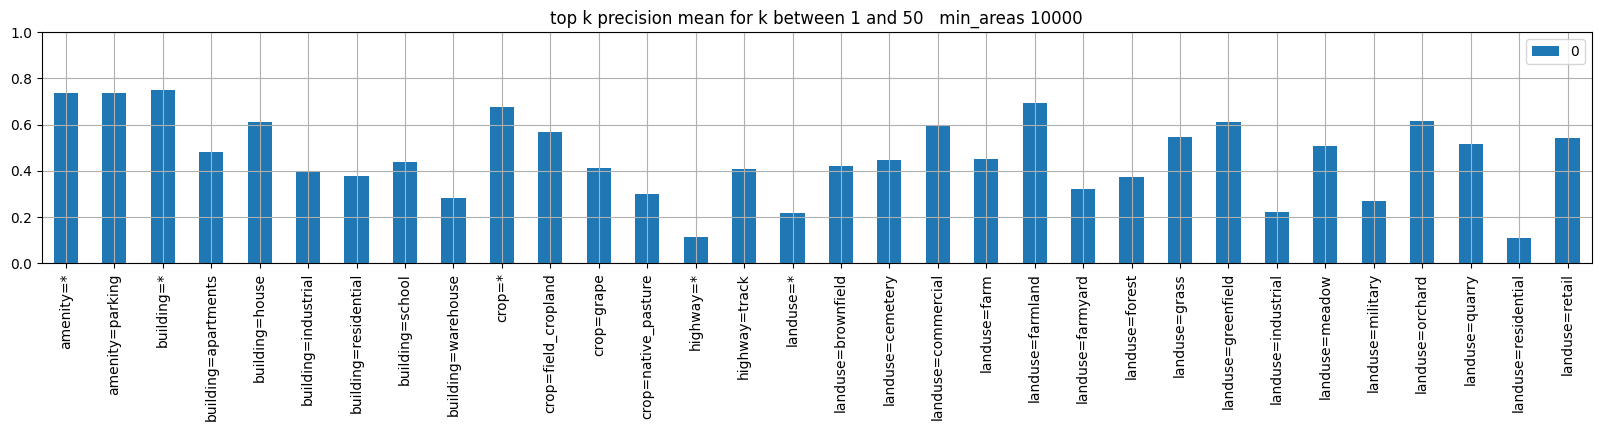

In [98]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=1, 
                            maxk=50,
                            min_areas=10000,
                            n_samples=5000,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.5min finished


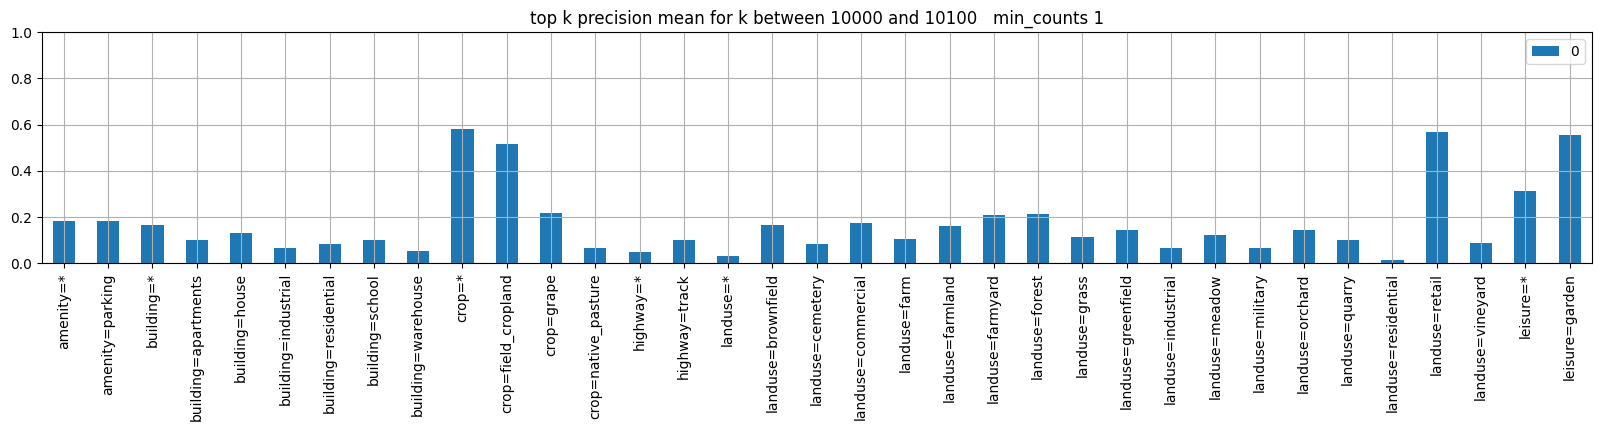

In [99]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=10000, 
                            maxk=10100,
                            min_counts=1,
                            n_samples=5000,
                            plot=True);